# Statistical Analysis

[This notebook](https://github.com/dattalab/keypoint-moseq/blob/main/docs/source/analysis.ipynb) contains routines for analyzing the output of keypoint-MoSeq.

```{note}
The interactive widgets require jupyterlab launched from the `keypoint_moseq` environment. They will not work properly in jupyter notebook.
```


## Setup

We assume you have already have keypoint-MoSeq outputs that are organized as follows.
```
<project_dir>/               ** current working directory
└── <model_name>/            ** model directory
    ├── results.h5           ** model results
    └── grid_movies/         ** [Optional] grid movies folder
```
Use the code below to enter in your project directory and model name.

In [7]:
import keypoint_moseq as kpms

project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fps=20 # frames per second of the video

## Assign Groups

The goal of this step is to assign group labels (such as "mutant" or "wildtype") to each recording. These labels are important later for performing group-wise comparisons.
- The code below creates a table called `{project_dir}/index.csv` and launches a widget for editing the table. To use the widget:
    - Click cells in the "group" column and enter new group labels.
    - Hit `Save group info` when you're done.
- **If the widget doesn't appear**, you also edit the table directly in Excel or LibreOffice Calc.

In [2]:
kpms.interactive_group_setting(project_dir, model_name, index_filename='index.csv')

BokehModel(combine_events=True, render_bundle={'docs_json': {'7f4e0b0b-cc65-424c-ac0b-cf97b57f941c': {'version…

KeyError: 'data'

KeyError: 'data'

## Generate dataframes

Generate a pandas dataframe called `moseq_df` that contains syllable labels and kinematic information for each frame across all the recording sessions. 

In [9]:
#  CSV 파일의 'name' 컬럼에 있는 값들과 일치하는 키만 포함하는 새로운 dictionary를 만들어 return하는 코드
 
import csv

def extract_matching_results(csv_file, results_dict):
    # CSV 파일에서 name 컬럼의 값들을 읽어옵니다
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        names_in_csv = set(row['name'] for row in reader)
    
    # results_dict에서 CSV의 name과 일치하는 키-값 쌍만 추출합니다
    new_dict = {key: value for key, value in results_dict.items() if key in names_in_csv}
    
    return new_dict

In [15]:
import os
index_filename = "index_z1.5.csv"

results_dict = kpms.load_results(project_dir, model_name)
results_dict = extract_matching_results(csv_file=os.path.join(project_dir,index_filename), results_dict=results_dict)
moseq_df = kpms.compute_moseq_df(project_dir, model_name, results_dict=results_dict, fps=fps, smooth_heading=True, index_filename=index_filename) 
moseq_df

,name,centroid_x,centroid_y,centroid_z,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,pre101,-4.890107,5.460056,1.800803,0.423362,0.000000,0.000000,7,0,control,True
1,pre101,-4.269766,5.373690,0.887762,0.452157,0.140808,22.144306,7,1,control,False
2,pre101,-4.569123,5.635958,1.173214,0.423362,0.297305,9.795562,7,2,control,False
3,pre101,-4.900844,5.466158,1.408959,0.452157,0.475994,8.819206,7,3,control,False
4,pre101,-4.684514,5.418027,1.637164,0.452157,0.668536,6.362174,7,4,control,False
...,...,...,...,...,...,...,...,...,...,...,...
873195,pre515,7.301109,-7.684746,4.589743,-0.685434,-0.536681,17.367390,2,11795,susceptible,False
873196,pre515,7.286511,-7.731138,4.522948,-0.716127,-0.418509,1.652496,2,11796,susceptible,False
873197,pre515,7.020144,-7.343358,4.684829,-0.716127,-0.308097,9.950481,2,11797,susceptible,False
873198,pre515,6.738294,-6.960769,4.991628,-0.758452,-0.203938,11.312629,2,11798,susceptible,False


Next generate a dataframe called `stats_df` that contains summary statistics for each syllable in each recording session, such as its usage frequency and its distribution of kinematic parameters.

In [10]:
import os
import pandas as pd
index_filename = "index_z1.5.csv"
results_dict = kpms.load_results(project_dir, model_name)
results_dict = extract_matching_results(csv_file=os.path.join(project_dir,index_filename), results_dict=results_dict)
index_filename = index_filename
min_frequency = 0.01
moseq_df = pd.read_csv(os.path.join(project_dir, model_name, 'moseq_df_z1.5_scalars.csv'), encoding='utf-8')
features_col = ["heading", "angular_velocity", "velocity_px_s", 
                "distance_from_origin", "velocity_xy", "velocity_z","length", "height", "torso_angle","angle_to_origin"]

stats_df = kpms.compute_stats_df(
    project_dir,
    model_name,
    moseq_df, 
    results_dict=results_dict,
    min_frequency=min_frequency,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=fps,
    index_filename=index_filename,
    features_col=features_col
    )                    # frame rate of the video from which keypoints were inferred

stats_df

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,...,torso_angle_mean,torso_angle_std,torso_angle_min,torso_angle_max,angle_to_origin_mean,angle_to_origin_std,angle_to_origin_min,angle_to_origin_max,frequency,duration
0,control,pre101,0,0.300114,1.743290,-3.065187,3.126728,0.041151,6.183400,-124.841955,...,1.724026,1.359068,0.000780,3.141055,1.977648,0.802466,0.022278,3.137151,0.121726,0.525949
1,control,pre101,1,0.192304,1.486307,-3.137526,3.114187,0.123514,6.251990,-122.839748,...,1.770177,1.206371,0.002284,3.140380,1.505525,0.675582,0.007184,3.141054,0.077042,0.403000
2,control,pre101,2,0.305774,1.851624,-3.121521,3.113962,-0.053589,11.705295,-125.537627,...,1.767611,1.179903,0.001315,3.141214,1.819734,0.716660,0.007908,3.094381,0.072419,0.369149
3,control,pre101,3,-0.036918,1.882042,-3.125108,3.133265,0.129068,10.886630,-125.438351,...,1.583414,1.407583,0.001096,3.140590,1.983044,0.725351,0.002720,3.139471,0.070878,0.722826
4,control,pre101,4,-0.087757,1.867114,-3.129096,3.135656,0.016667,11.494598,-125.091086,...,1.490511,1.332433,0.000638,3.141373,1.704970,0.767326,0.003481,3.140454,0.084746,1.069091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,susceptible,pre515,15,-0.905697,1.324931,-2.395697,2.350345,0.150789,0.362615,-0.446533,...,2.327469,1.285386,0.006784,3.128996,1.323763,0.828853,0.167700,2.685581,0.005076,0.960000
1496,susceptible,pre515,17,-0.612740,1.902266,-2.557037,2.978161,-0.490278,0.868048,-2.846438,...,1.024051,0.677709,0.068990,3.106745,1.380207,0.590034,0.169638,3.140551,0.009137,0.888889
1497,susceptible,pre515,18,-0.287941,2.311465,-3.093878,3.114922,0.160539,10.439447,-125.275594,...,2.131837,0.838607,0.003222,3.097872,0.889885,0.446228,0.009976,1.693757,0.016244,0.909375
1498,susceptible,pre515,23,2.632228,0.253962,2.224416,2.839604,1.392337,0.468993,0.634371,...,2.887058,0.115092,2.732507,3.048363,1.658766,0.221333,1.426730,2.043551,0.001015,0.450000


### **Optional:** Save dataframes to csv
Uncomment the code below to save the dataframes as .csv files

In [11]:
import os
stats_output_filename = 'stats_df_z1.5_scalars.csv'

# save stats_df
save_dir = os.path.join(project_dir, model_name)
stats_df.to_csv(os.path.join(save_dir, stats_output_filename), index=False, encoding='utf-8')
print('Saved `stats_df` dataframe to', save_dir)

Saved `stats_df` dataframe to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21


In [5]:
import os
moseq_output_filename = 'moseq_df_z1.5.csv'
stats_output_filename = 'stats_df_z1.5.csv'


# save moseq_df
save_dir = os.path.join(project_dir, model_name) # directory to save the moseq_df dataframe
moseq_df.to_csv(os.path.join(save_dir, moseq_output_filename), index=False, encoding='utf-8')
print(f'Saved `moseq_df` dataframe to', save_dir)

# save stats_df
save_dir = os.path.join(project_dir, model_name)
stats_df.to_csv(os.path.join(save_dir, stats_output_filename), index=False, encoding='utf-8')
print('Saved `stats_df` dataframe to', save_dir)

Saved `moseq_df` dataframe to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21
Saved `stats_df` dataframe to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21


##  Label syllables

The goal of this step is name each syllable (e.g., "rear up" or "walk slowly").
- The code below creates an empty table at `{project_dir}/{model_name}/syll_info.csv` and launches an interactive widget for editing the table. To use the widget:
    - Select a syllable from the dropdown to display its grid movie.
    - Enter a name into the `label` column of the table (and optionally a short description too).
    - When you are done, hit `Save syllable info` at the bottom of the table.
- **If the widget doesn't appear**, you can also edit the file directly in Excel or LibreOffice Calc.

In [ ]:
kpms.label_syllables(project_dir, model_name, moseq_df) 

## Compare between groups

Test for statistically significant differences between groups of recordings. The code below takes a syllable property (e.g. frequency or duration), plots its disribution for each syllable across for each group, and also tests whether the property differs significantly between groups. The results are summarized in a plot that is saved to `{project_dir}/{model_name}/analysis_figures`.

There are two options for setting the order of syllables along the x-axis. When `order='stat'`, syllables are sorted by the mean value of the statistic. When `order='diff'`, syllables are sorted by the magnitude of difference between two groups that are determined by the `ctrl_group` and `exp_group` keywords. Note `ctrl_group` and `exp_group` are not related to significance testing.

(Warning) stats_subtle_df에 있는 모든 group간 통계비교를 함.
만약 stats_subtle_df에 프로젝트 내 여러 group들이 섞여 있어서 통계비교를 원하지 않는다면 아래와 같이 원하는 그룹만 따로 추출하는 과정이 필요함.

In [2]:
import keypoint_moseq as kpms
import os
import pandas as pd

project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fps=20 # frames per second of the video

ctrl_group='susceptible'
exp_group='resilient'
stats_df_filename = 'stats_df_z1.5_scalars.csv' 

groups = [ctrl_group, exp_group] # groups to be plotted
stats_df = pd.read_csv(os.path.join(project_dir, model_name, stats_df_filename), encoding='utf-8')
stats_df = stats_df[stats_df['group'].isin(groups)]
stats_df

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,...,torso_angle_mean,torso_angle_std,torso_angle_min,torso_angle_max,angle_to_origin_mean,angle_to_origin_std,angle_to_origin_min,angle_to_origin_max,frequency,duration
376,resilient,pre102,0,-0.192644,1.848216,-3.117649,3.135957,-0.102431,10.114976,-124.236943,...,1.217973,1.331588,0.000271,3.140388,1.927774,0.718079,0.004927,3.133831,0.130435,0.493056
377,resilient,pre102,1,-0.024941,1.745981,-3.136276,3.131011,-0.359461,12.642252,-125.534052,...,1.461790,1.252177,0.008630,3.138920,1.500292,0.734391,0.003401,3.130595,0.101449,0.347024
378,resilient,pre102,2,0.183220,1.746224,-3.139859,3.127324,0.177593,9.568129,-124.963104,...,1.549367,1.120874,0.000807,3.140387,1.683323,0.875873,0.007123,3.140970,0.065217,0.477778
379,resilient,pre102,3,0.301866,1.794843,-3.140285,3.138301,-0.277193,8.925764,-124.369298,...,1.277723,1.406503,0.000363,3.141567,1.852162,0.661120,0.014360,3.139845,0.085749,0.695775
380,resilient,pre102,4,0.294351,2.004163,-3.135358,3.141584,0.379439,12.194261,-125.024577,...,1.277806,1.259810,0.000355,3.141562,1.693600,0.740647,0.001445,3.140184,0.078502,0.968462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,susceptible,pre515,15,-0.905697,1.324931,-2.395697,2.350345,0.150789,0.362615,-0.446533,...,2.327469,1.285386,0.006784,3.128996,1.323763,0.828853,0.167700,2.685581,0.005076,0.960000
1496,susceptible,pre515,17,-0.612740,1.902266,-2.557037,2.978161,-0.490278,0.868048,-2.846438,...,1.024051,0.677709,0.068990,3.106745,1.380207,0.590034,0.169638,3.140551,0.009137,0.888889
1497,susceptible,pre515,18,-0.287941,2.311465,-3.093878,3.114922,0.160539,10.439447,-125.275594,...,2.131837,0.838607,0.003222,3.097872,0.889885,0.446228,0.009976,1.693757,0.016244,0.909375
1498,susceptible,pre515,23,2.632228,0.253962,2.224416,2.839604,1.392337,0.468993,0.634371,...,2.887058,0.115092,2.732507,3.048363,1.658766,0.221333,1.426730,2.043551,0.001015,0.450000


In [1]:
# 내 프로젝트에서 stats_df의 'control'은 ANOVA등 통계 분석에 R, S와 함께 비교될 수 없음. 따라서 아래처럼 groups에 지정된 group만 필터링하여, 통계분석에 사용하도록 설정해야 함.
# 왜냐하면 아래 kpms.plot_syll_stats_with_sem 함수는 stats_df의 모든 그룹에 대해 통계처리를 하기 때문.
import keypoint_moseq as kpms
import os
import pandas as pd

# project_dir = r'G:\\공유 드라이브\\Broad X ACTNOVA\\kp-moseq\\trial2_without_nose_tip'
# model_name = '2024_03_27-21_14_34'
# index_filename = "index_all.csv"
# fps = 30
ctrl_group='susceptible'
exp_group='resilient'
stats_df_filename = 'stats_df_z1.5_scalars.csv' 

groups = [ctrl_group, exp_group] # groups to be plotted
stats_df = pd.read_csv(os.path.join(project_dir, model_name, stats_df_filename), encoding='utf-8')
stats_df = stats_df[stats_df['group'].isin(groups)]
stats_df

NameError: name 'project_dir' is not defined

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\distance_from_origin_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_xy_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_z_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\length_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\height_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\torso_angle_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angle_to_origin_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\frequency_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1172: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\duration_stat_stats.png


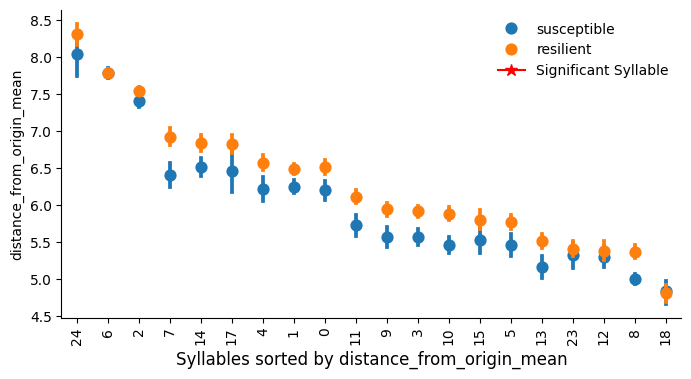

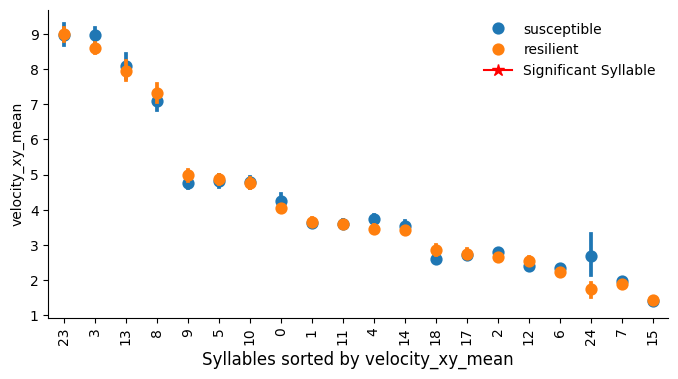

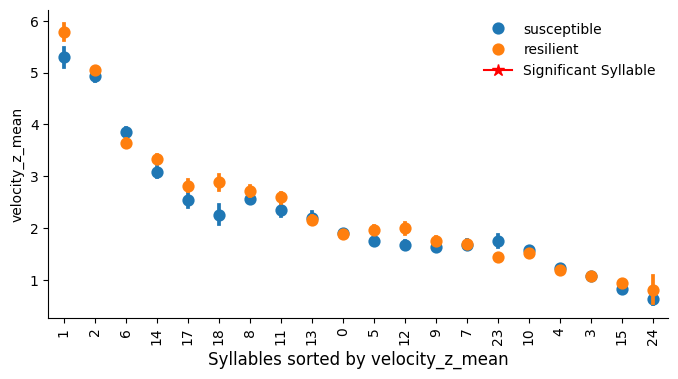

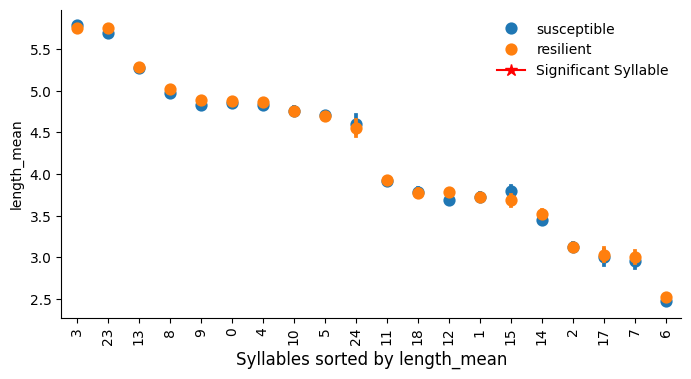

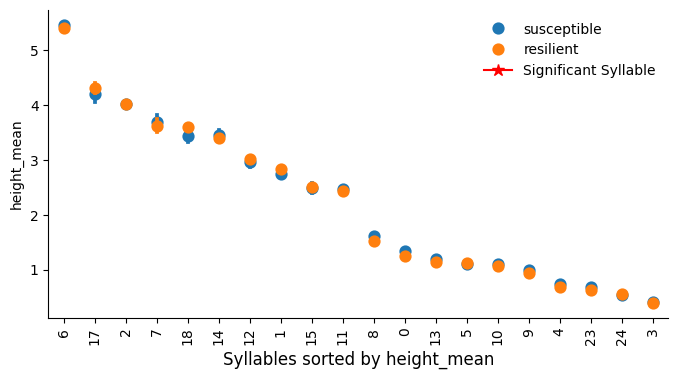

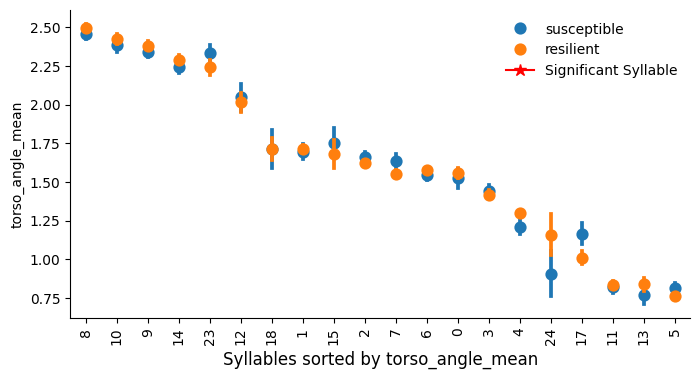

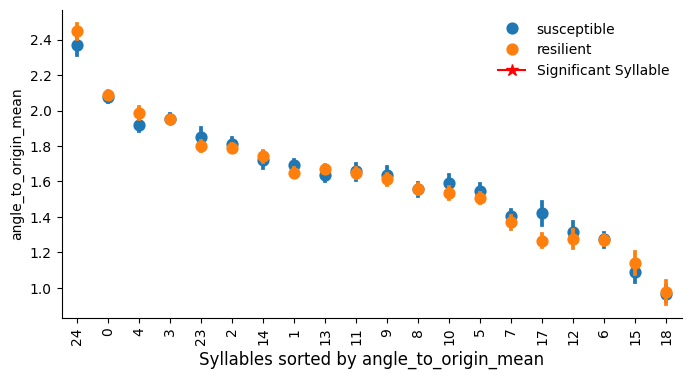

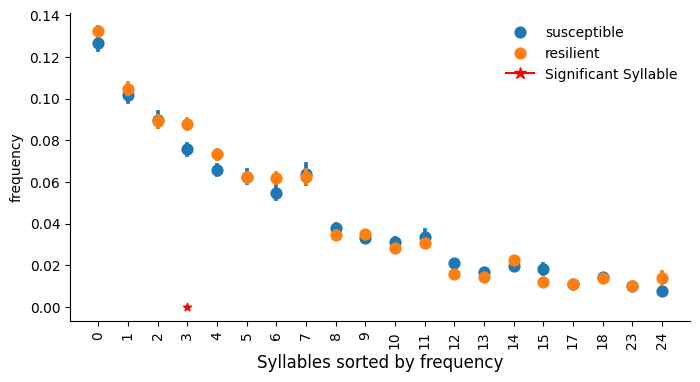

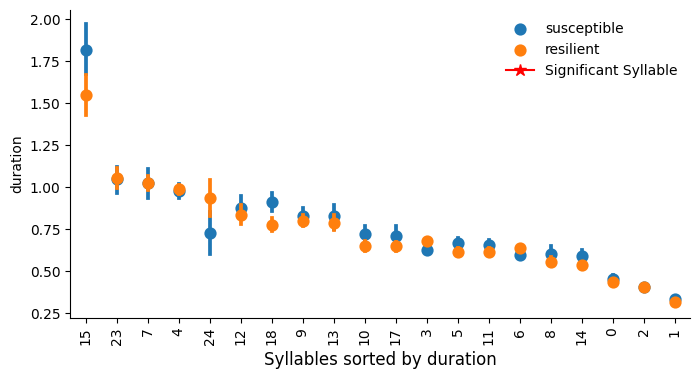

In [3]:
thresh=0.05   # Q value for statistical significance (bh-fdr correction)
#stats = ['frequency', 'duration', 'distance_from_origin_mean','velocity_xy_mean','velocity_z_mean','length_mean','height_mean','torso_angle_mean']
stats = ['distance_from_origin','velocity_xy','velocity_z','length','height','torso_angle','angle_to_origin']
# postfix = ['mean', 'std','max','min']
postfix = ['mean']
stats2 = [f'{stat}_{post}' for stat in stats for post in postfix]
stats2 = stats2 + ['frequency','duration']

for stat in stats2:
    kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_name,
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=thresh,      # significance threshold
    stat=stat, #statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order='stat',     # order syllables by overall frequency ("stat") or degree of difference ("diff")
    ctrl_group=ctrl_group,   # name of the control group for statistical testing
    exp_group=exp_group,    # name of the experimental group for statistical testing
    figsize=(8, 4),   # figure size    
    join=False,   # whether to join syllables with a line
    groups=groups, # groups to be plotted
    #groups=stats_df['group'].unique(), # groups to be plotted
    mc_method='hs' # multiple comparison correction method ('hs' for Hochberg-Sidak, 'fdr_bh' for Benjamini-Hochberg)
    )

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_std_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_min_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_max_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_std_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_min_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_max_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_std_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_min_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_max_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\frequency_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\duration_stat_stats.png


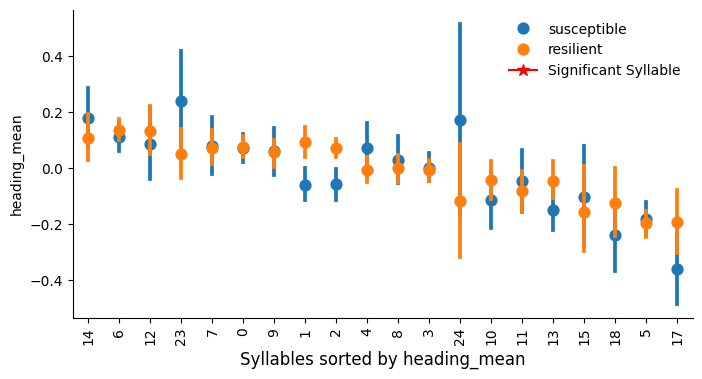

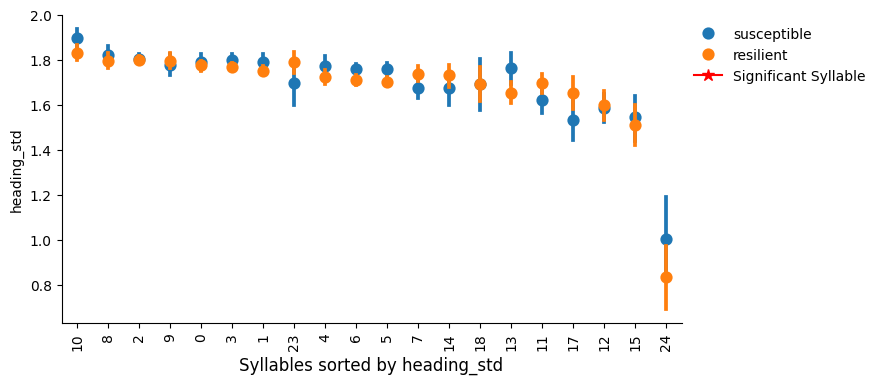

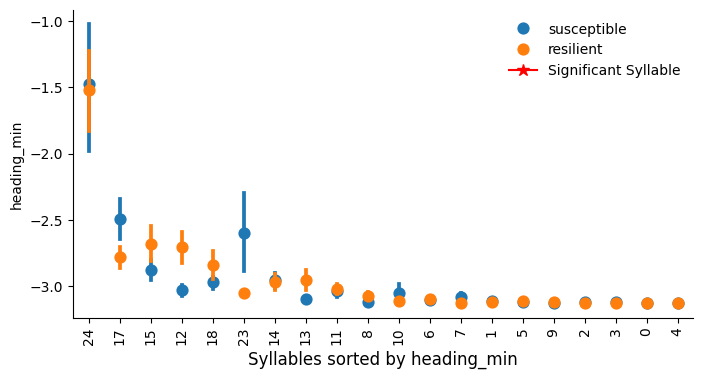

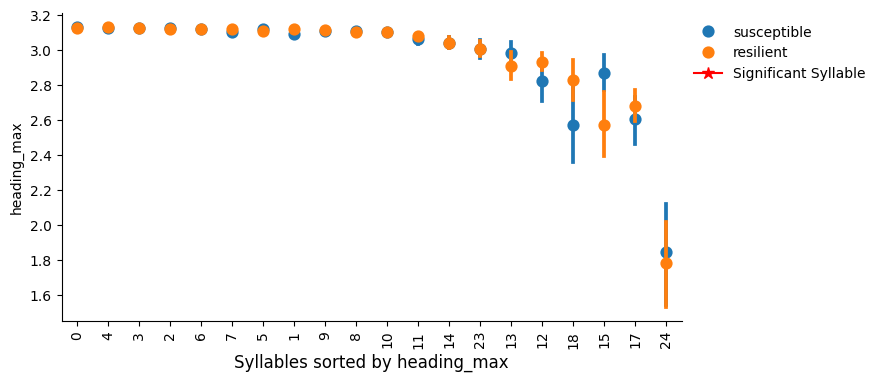

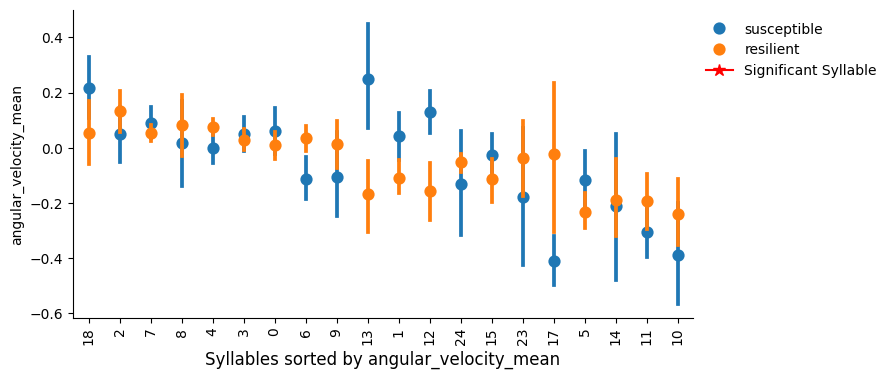

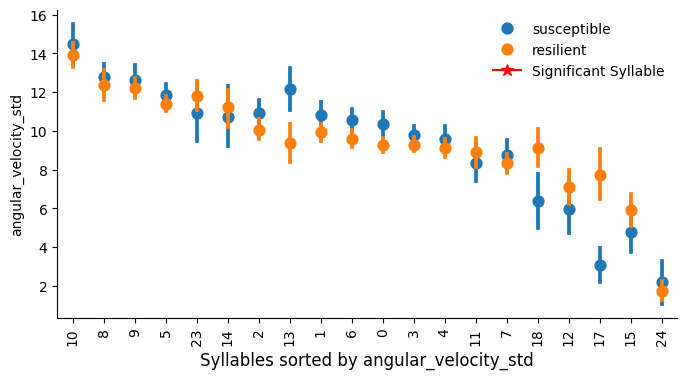

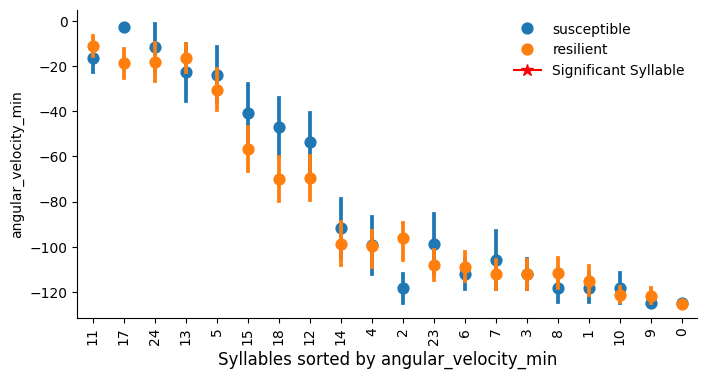

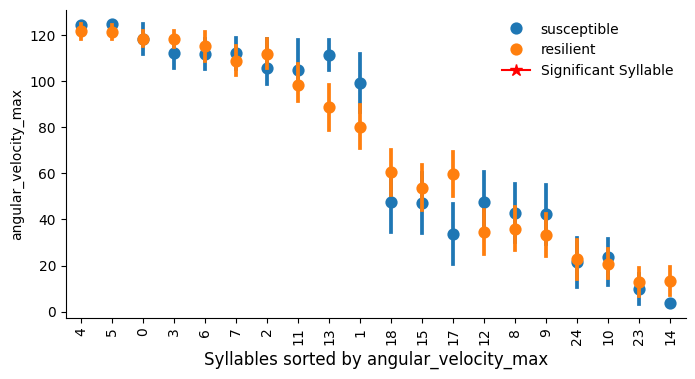

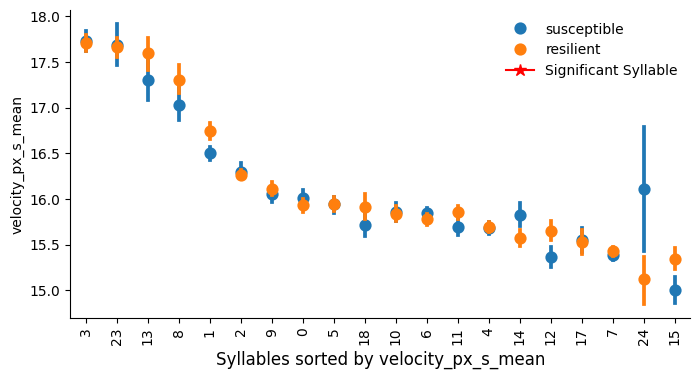

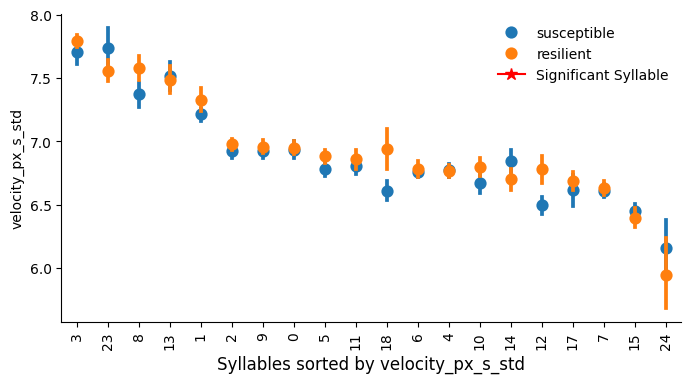

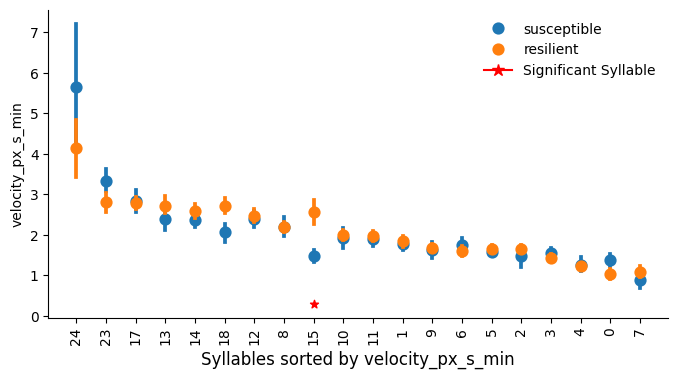

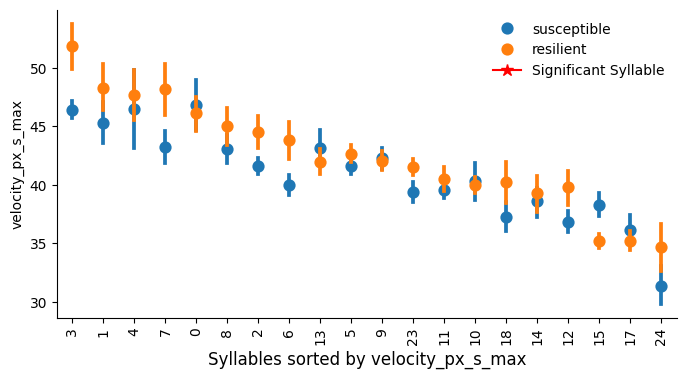

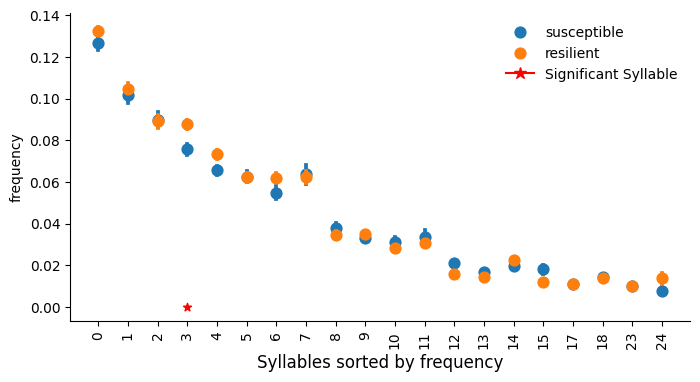

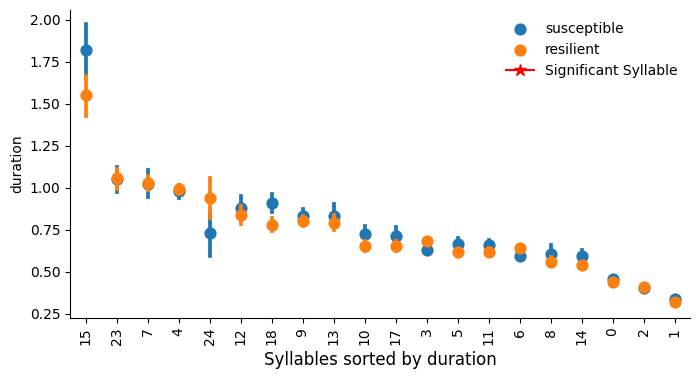

In [7]:
thresh=0.05   # p-value threshold
stats = ['heading_mean', 'heading_std',
       'heading_min', 'heading_max', 'angular_velocity_mean',
       'angular_velocity_std', 'angular_velocity_min', 'angular_velocity_max',
       'velocity_px_s_mean', 'velocity_px_s_std', 'velocity_px_s_min',
       'velocity_px_s_max', 'frequency', 'duration']

for stat in stats:
    kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_name,
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=thresh,      # significance threshold
    stat=stat, #statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order='stat',     # order syllables by overall frequency ("stat") or degree of difference ("diff")
    ctrl_group=ctrl_group,   # name of the control group for statistical testing
    exp_group=exp_group,    # name of the experimental group for statistical testing
    figsize=(8, 4),   # figure size    
    join=False,   # whether to join syllables with a line
    groups=groups, # groups to be plotted
    #groups=stats_df['group'].unique(), # groups to be plotted
    )

In [9]:
stats = ['distance_from_origin','velocity_xy','velocity_z','length','height','torso_angle','angle_to_origin']
# postfix = ['mean', 'std','max','min']
postfix = ['mean']
stats2 = [f'{stat}_{post}' for stat in stats for post in postfix]
stats2 = stats2 + ['frequency','duration']

for statistic in stats2:
    df_k_real, dunn_results_df, sig_pairs = kpms.run_kruskal(stats_df, statistic=statistic, thresh=0.05, mc_method='hs')
    # save df_k_real
    save_dir = os.path.join(project_dir, model_name) # directory to save the moseq_df dataframe
    df_k_real.to_csv(os.path.join(save_dir, f'df_k_real_z1.5_{statistic}.csv'), index=False, encoding='utf-8')

### Transition matrices
Generate heatmaps showing the transition frequencies between syllables.

기존 제공 코드: 전체 데이터를 concat후, TP 구한 후, bigram normalization해서 그룹의 평균을 구함.

아래 코드: 각 results csv 파일마다 TP 구한 후, bigram normalization한 후, 평균값을 내서 그룹의 평균을 구함.

In [12]:
import keypoint_moseq as kpms
import os
import pandas as pd

project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fps=20 # frames per second of the video
ctrl_group='susceptible'
exp_group='resilient'

# 데이터 로드 및 전처리
index_filename = "index_z1.5.csv"
results_dict = kpms.load_results(project_dir, model_name)
results_dict = kpms.extract_matching_results(csv_file=os.path.join(project_dir,index_filename), results_dict=results_dict)
index_filepath = os.path.join(project_dir, index_filename)
index_data = pd.read_csv(index_filepath, index_col=False)
normalize = 'bigram'
min_frequency = 0.01
selected_groups = [exp_group, ctrl_group]  # selected_groups는 바꾸지 말기. group1, group2를 선택하기 위해 사용

['control', 'resilient', 'susceptible']
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\transition_matrix_resilient.png
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\transition_matrix_susceptible.png


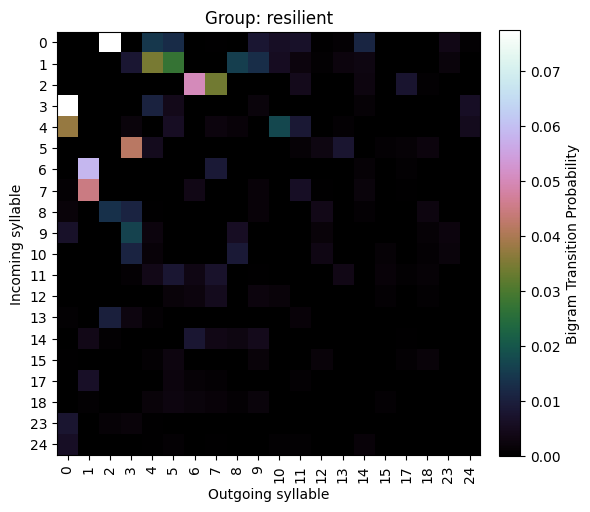

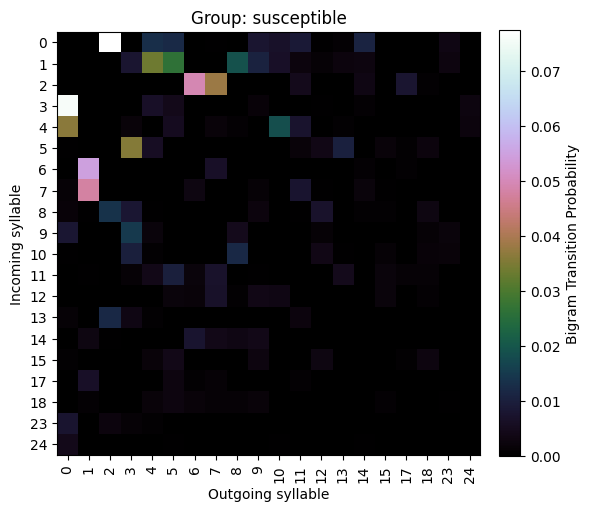

In [14]:
# 아래 module에는 selected_groups를 사용하지 않기. 왜냐면 selected_groups에서의 min_frequency 이상의 syllable만 사용하기 때문. 
# 실제 앞에서의 분석에서는 index.csv에 있는 모든 개체에 대해 frequency를 계산하기 때문에, 이를 기준으로 syllable을 선택해야 함.
group_tps, usages, individual_tps, label_group, recordings, syll_include, group_list = kpms.get_group_trans_mats_from_individual(
    project_dir, model_name, index_data, results_dict=results_dict, normalize=normalize, min_frequency=min_frequency, normalize_individual_tp='bigram')

print(group_list)

# (생략가능. 확인용) group_list에서 selected_groups의 index를 찾아서 group_tps에서 해당 index의 transition matrix만 추출 
group_tps_index = [group_list.index(group) for group in selected_groups] 
group_tps = [group_tps[i] for i in group_tps_index]

kpms.visualize_save_each_transition_bigram(
    project_dir, model_name, selected_groups, group_tps, syll_include, normalize=normalize,
    show_syllable_names=True
)

In [16]:
# Run and Save statistics result
thres = 0.05    # p-value threshold
thres_fdr_bh = 0.05 # Q value for statistical significance (bh-fdr correction)

transition_results_df = kpms.run_permutation_group_tps(project_dir, model_name, group_tps, individual_tps, label_group, syll_include, selected_groups, n_resamples=5000, threshold=thres,threshold_fdr=thres_fdr_bh)

# Import the result
#transition_results_df = pd.read_csv(r'G:\공유 드라이브\Broad X ACTNOVA\kp-moseq\trial2_without_nose_tip\2024_03_27-21_14_34\Transition_SETD1A_HET_M_vs_SETD1A_WT_M\transition_results.csv')

Significant transitions between resilient and susceptible (without correction):
Syllable 0 -> Syllable 4
Syllable 0 -> Syllable 11
Syllable 0 -> Syllable 24
Syllable 1 -> Syllable 7
Syllable 1 -> Syllable 8
Syllable 1 -> Syllable 9
Syllable 3 -> Syllable 4
Syllable 3 -> Syllable 9
Syllable 3 -> Syllable 12
Syllable 3 -> Syllable 24
Syllable 4 -> Syllable 7
Syllable 4 -> Syllable 9
Syllable 4 -> Syllable 11
Syllable 4 -> Syllable 24
Syllable 5 -> Syllable 0
Syllable 5 -> Syllable 3
Syllable 5 -> Syllable 11
Syllable 5 -> Syllable 13
Syllable 5 -> Syllable 14
Syllable 5 -> Syllable 15
Syllable 5 -> Syllable 17
Syllable 6 -> Syllable 1
Syllable 6 -> Syllable 2
Syllable 6 -> Syllable 7
Syllable 8 -> Syllable 3
Syllable 8 -> Syllable 9
Syllable 8 -> Syllable 11
Syllable 8 -> Syllable 12
Syllable 8 -> Syllable 15
Syllable 9 -> Syllable 3
Syllable 9 -> Syllable 8
Syllable 10 -> Syllable 0
Syllable 10 -> Syllable 4
Syllable 10 -> Syllable 8
Syllable 10 -> Syllable 13
Syllable 10 -> Syllable 18

In [3]:
## 기존 코드. project_dir과 model_name에 있는 모든 데이터셋 분석.

## 주의! trsans_mats, usages의 경우 index (0,1,2,...)가 groups의 순서대로. groups 이름이 key로 할당되는게 아님.
## 따라서 kpms.generate_transition_matrices()의 output인 groups를 임의로 groups=['resilient','susceptible'] 등으로 바꾸지 말기.

# index_filename = "index_all.csv"
# normalize='bigram' # normalization method ("bigram", "rows" or "columns")

# trans_mats, usages, groups, syll_include=kpms.generate_transition_matrices(
#     project_dir, model_name, normalize=normalize,
#     min_frequency=0.005, # minimum syllable frequency to include
#     index_filename=index_filename
# )    

# kpms.visualize_save_each_transition_bigram(
#     project_dir, model_name, groups, trans_mats, syll_include, normalize=normalize, 
#     show_syllable_names=True # label syllables by index (False) or index and name (True)
# )

Group(s): GRIA3_MUT_M, GRIA3_WT_M, SETD1A_HET_F, SETD1A_HET_M, SETD1A_WT_F, SETD1A_WT_M


### Syllable Transition Graph
Render transition rates in graph form, where nodes represent syllables and edges represent transitions between syllables, with edge width showing transition rate for each pair of syllables (secifically the max of the two transition rates in each direction).

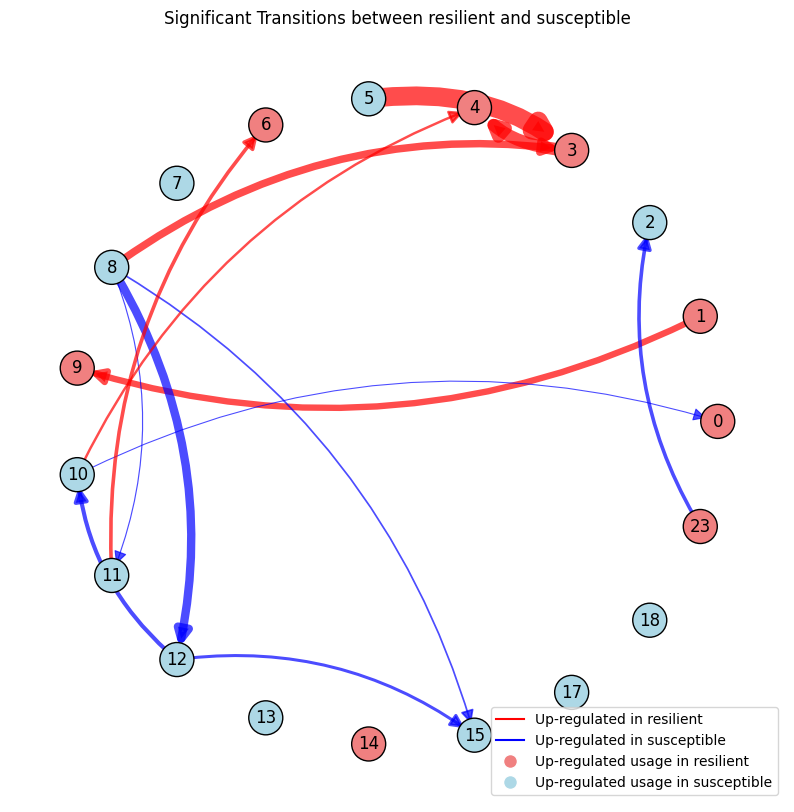

In [16]:
kpms.plot_significant_transition_graph(project_dir, model_name, selected_groups[0], selected_groups[1], transition_results_df, syll_include, usages, layout='circular', node_scaling=2000, show_syllable_names=True)


# 기존 코드 (transition prob.)

In [ ]:
# # Generate a transition graph for each single group

# kpms.plot_transition_graph_group(
#     project_dir, model_name, 
#     groups, trans_mats, usages, syll_include, 
#     layout='circular',        # transition graph layout ("circular" or "spring")
#     show_syllable_names=False # label syllables by index (False) or index and name (True)
# )

In [ ]:
# # Generate a difference-graph for each pair of groups.

# kpms.plot_transition_graph_difference(project_dir, model_name, 
#                                       groups, trans_mats, usages, syll_include, 
#                                       layout='circular') # transition graph layout ("circular" or "spring")